# Cargar datos desde drive

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configurar para usar TODA la capacidad
import os
import gc
import psutil

# Configurar variables de entorno
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.9'

# Configurar NumPy para usar todos los cores
os.environ['OMP_NUM_THREADS'] = str(psutil.cpu_count())
os.environ['OPENBLAS_NUM_THREADS'] = str(psutil.cpu_count())

print(f"🚀 CPU Cores: {psutil.cpu_count()}")
print(f"🧠 RAM Total: {psutil.virtual_memory().total / (1024**3):.1f}GB")
print(f"🎮 GPU: Tesla T4 (15.36GB)")

🚀 CPU Cores: 8
🧠 RAM Total: 51.0GB
🎮 GPU: Tesla T4 (15.36GB)


In [ ]:
pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=442bed565bdfa4781dc5c12fa5cfbe1200a1f8da03674aee4f479ec74bdc1a89
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [ ]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

# Configurar Dask para usar TODA la RAM disponible
cluster = LocalCluster(
    n_workers=4,
    threads_per_worker=2,
    memory_limit='12GB',  # Por worker
    dashboard_address=':8787'
)
client = Client(cluster)

# Estrategia: Procesar en chunks de ~40GB
def load_massive_dataset(file_path):
    # Usar 40GB de los 53GB disponibles para datos
    chunk_size = '10GB'

    df = dd.read_csv(
        file_path,
        blocksize=chunk_size,
        assume_missing=True,
        dtype_backend='pyarrow'  # Más eficiente en memoria
    )

    print(f"📊 Dataset cargado: {df.npartitions} particiones")
    return df

# Función de monitoreo específica para tu setup
def monitor_t4_resources():
    import GPUtil

    # RAM
    ram = psutil.virtual_memory()
    ram_used = ram.used / (1024**3)
    ram_total = ram.total / (1024**3)

    # GPU
    gpu = GPUtil.getGPUs()[0]
    gpu_used = gpu.memoryUsed / 1024
    gpu_total = gpu.memoryTotal / 1024

    print(f"🧠 RAM: {ram_used:.1f}/{ram_total:.1f}GB ({ram.percent:.1f}%)")
    print(f"🎮 T4 GPU: {gpu_used:.1f}/{gpu_total:.1f}GB ({gpu.memoryUtil*100:.1f}%)")
    print(f"⚡ GPU Util: {gpu.load*100:.1f}%")

    return ram.percent < 90 and gpu.memoryUtil < 0.9

monitor_t4_resources()

/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46075 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36711
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:46075/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43511'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34297'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44807'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39099'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:38737 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38737
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:35738
INFO:distributed.sch

🧠 RAM: 2.5/51.0GB (5.9%)
🎮 T4 GPU: 0.1/15.0GB (0.7%)
⚡ GPU Util: 0.0%


True

In [ ]:
# Configuración optimizada para modelos ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Configurar para usar GPU con sklearn-gpu si está disponible
try:
    from cuml import RandomForestClassifier, LogisticRegression
    from cuml.model_selection import train_test_split as gpu_train_test_split
    USE_GPU_ML = True
    print("✅ RAPIDS cuML disponible - ML acelerado por GPU")
except ImportError:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    USE_GPU_ML = False
    print("⚠️ Usando sklearn CPU - Instalar RAPIDS para GPU ML")

# Configuración para máximo paralelismo CPU
if not USE_GPU_ML:
    n_jobs = psutil.cpu_count()  # Usar todos los cores
    print(f"🔧 Configurado para {n_jobs} cores en paralelo")

✅ RAPIDS cuML disponible - ML acelerado por GPU


In [ ]:
import tensorflow as tf
import torch

# TensorFlow - Usar toda la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=15000)]
    )

# PyTorch - Configuración T4
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True
    print(f"🎮 PyTorch GPU: {torch.cuda.get_device_name()}")

🎮 PyTorch GPU: Tesla T4


In [ ]:
import pandas as pd

# Cargar los datos balanceados y no balanceados
df_train_resampled = pd.read_csv('/content/drive/MyDrive/train_resampled.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

# Verificar los datos cargados
print("DataFrame de Entrenamiento Resampleado:")
print(df_train_resampled)

print("\nDataFrame de Prueba:")
print(df_test)

DataFrame de Entrenamiento Resampleado:
      exportacion   importacion  zona_portuaria_BARRANCABERMEJA  \
0       -0.504650 -1.946601e-01                           False   
1        0.945448  2.288461e+00                           False   
2        0.000000 -6.843999e-01                           False   
3       -0.504650 -6.516398e-01                           False   
4       -0.504650  1.717848e+00                           False   
...           ...           ...                             ...   
9559    -0.504650 -6.843999e-01                           False   
9560    -0.504650 -6.843999e-01                           False   
9561    -0.504650 -6.843999e-01                            True   
9562    -0.504650  8.894084e-17                           False   
9563    -0.504650  8.894084e-17                           False   

      zona_portuaria_BARRANQUILLA  zona_portuaria_BUENAVENTURA  \
0                           False                        False   
1                      

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#Se separa variables predictoras y objetivo
X_train_resampled = df_train_resampled.drop("tipo_servicio", axis = 1)
y_train_resampled = df_train_resampled['tipo_servicio']

X_test = df_test.drop("tipo_servicio", axis = 1)
Y_test = df_test['tipo_servicio']

# Validacion cruzada

In [ ]:
#Validación Cruzada
from sklearn.model_selection import cross_validate, StratifiedKFold


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #Muestreo estratificado

# ***METODOS DE APRENDIZAJE***

REGRESION LOGISTICA


KNN

SVM

NEURONAL NETWORK

RANDOM FOREST

GRADIENTE BOOSTING

XGBOOST





In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


In [ ]:
# --- Recopilación de F1-Scores de Cross-Validation para ANOVA y Resultados ---
all_f1_scores_from_cv = [] # Lista de arrays, cada array son los F1s de un modelo en los folds
model_names_for_anova = []   # Nombres de los modelos, en orden

In [ ]:
results = {}
for name, model in models.items():
    scores_accuracy = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')
    scores_precision = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='precision')
    scores_recall = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='recall')
    scores_f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')

    all_f1_scores_from_cv.append(scores_f1)
    model_names_for_anova.append(name)

    results[name] = {
        'Accuracy': scores_accuracy.mean(),
        'Precision': scores_precision.mean(),
        'Recall': scores_recall.mean(),
        'F1 Score': scores_f1.mean()
    }

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/range.py", line 413, in get_loc
    return self._range.index(new_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: -1 is not in range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
   

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.999686   0.999374  1.000000  0.999687
KNN                  0.998954   0.999582  0.998326  0.998953
SVM                  0.999686   0.999374  1.000000  0.999687
Neural Network       0.999686   0.999374  1.000000  0.999687
Random Forest        0.999686   0.999374  1.000000  0.999687
Gradient Boosting    0.999686   0.999374  1.000000  0.999687
XGBoost              0.999686   0.999374  1.000000  0.999687


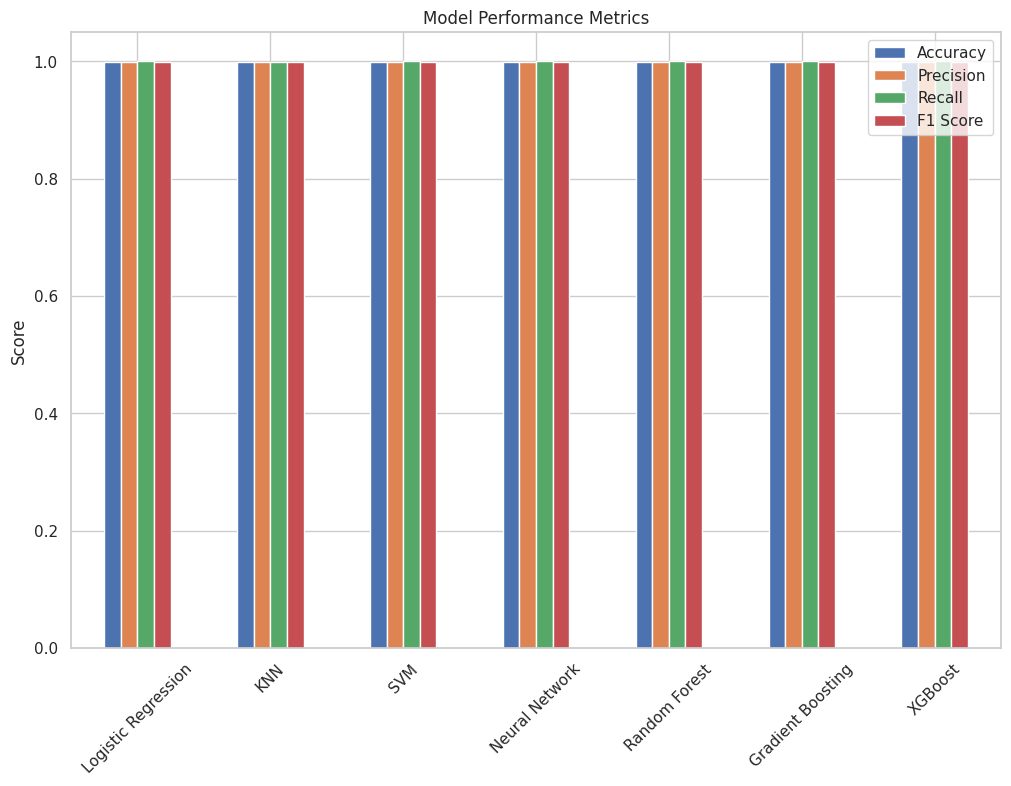

In [ ]:
results_df = pd.DataFrame(results).T
print(results_df)

# Visualización de resultados
sns.set(style="whitegrid")
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# Anova y turkey

In [ ]:

# Realizar ANOVA
f_stat, p_value_anova = f_oneway(*all_f1_scores_from_cv)
print(f"Estadístico F de ANOVA: {f_stat:.4f}, Valor p de ANOVA: {p_value_anova:.4g}")

final_best_models = []
candidate_models_from_tukey_names = set()

# Solo proceder con Tukey si ANOVA fue concluyente
if p_value_anova is not None and not np.isnan(p_value_anova) and p_value_anova < 0.05:
    print("\nANOVA es significativa. Realizando prueba de Tukey HSD...")

    # ... (código para aplanar scores y crear labels, esto parece correcto) ...
    flat_f1_scores = [score for sublist in all_f1_scores_from_cv for score in sublist]
    group_labels = []
    for i, model_name_label in enumerate(model_names_for_anova):
        group_labels.extend([model_name_label] * len(all_f1_scores_from_cv[i]))


    tukey_results = pairwise_tukeyhsd(endog=np.array(flat_f1_scores),
                                      groups=np.array(group_labels),
                                      alpha=0.05)
    print("\nResultados de la Prueba de Tukey HSD (salida directa del objeto):")
    print(tukey_results)

    # --- MODIFICACIÓN MÁS PROFUNDA AQUÍ para procesar la tabla de Tukey ---
    try:
        table_obj = None
        summary_obj = tukey_results.summary()

        # Intento 1: ¿Es summary_obj directamente la SimpleTable?
        if hasattr(summary_obj, 'data') and isinstance(summary_obj.data, list) and len(summary_obj.data) > 0:
             temp_header_check = [str(h).strip() for h in summary_obj.data[0]]
             if all(col_name in temp_header_check for col_name in ['group1', 'group2', 'p-adj']):
                 table_obj = summary_obj
                 print("DEBUG: Se ha tomado tukey_results.summary() directamente como la tabla de resultados.")

        # Intento 2: Si no, ¿summary_obj tiene un atributo .tables?
        elif hasattr(summary_obj, 'tables') and isinstance(summary_obj.tables, list):
             # Buscar una tabla con datos que parezca la de resultados
             for table in summary_obj.tables:
                 if hasattr(table, 'data') and isinstance(table.data, list) and len(table.data) > 0:
                     temp_header_check = [str(h).strip() for h in table.data[0]]
                     if all(col_name in temp_header_check for col_name in ['group1', 'group2', 'p-adj']):
                         table_obj = table
                         print(f"DEBUG: Se ha tomado una tabla encontrada dentro de .tables como la tabla de resultados.")
                         break # Una vez encontrada, salir del bucle

        if table_obj is None:
            raise ValueError("No se pudo identificar la tabla de resultados de Tukey con el formato esperado.")

        # Ahora, table_obj DEBERÍA ser la SimpleTable correcta.
        if not table_obj.data or len(table_obj.data) < 2:
            print("Advertencia: La tabla de resultados de Tukey identificada (table_obj.data) está vacía o no tiene suficientes filas de datos.")
            # candidate_models_from_tukey_names ya está inicializado como set() vacío
        else:
            header_actual = [str(h).strip() for h in table_obj.data[0]]
            data_rows_actual = table_obj.data[1:]

            print(f"DEBUG: Encabezado extraído de la tabla de Tukey: {header_actual}")

            required_columns = ['group1', 'group2', 'p-adj']
            if not all(col in header_actual for col in required_columns):
                missing = [col for col in required_columns if col not in header_actual]
                raise ValueError(f"Faltan columnas requeridas en el encabezado de Tukey: {missing}. Encabezado encontrado: {header_actual}")

            idx_group1 = header_actual.index('group1')
            idx_group2 = header_actual.index('group2')
            idx_p_adj = header_actual.index('p-adj')

            candidate_models_from_tukey_names = set() # Asegurarse de reiniciar por si acaso

            for row_idx, row in enumerate(data_rows_actual):
                try:
                    # Verificación básica del tamaño de la fila
                    if len(row) <= max(idx_group1, idx_group2, idx_p_adj):
                         print(f"Advertencia: Fila {row_idx+1} de datos de Tukey tiene menos elementos de los esperados. Saltando esta fila: {row}")
                         continue

                    group1_name = str(row[idx_group1]).strip()
                    group2_name = str(row[idx_group2]).strip()

                    p_adj_value_str = str(row[idx_p_adj]).strip()
                    # Manejar posibles valores no numéricos (como 'nan' strings o espacios)
                    if p_adj_value_str.lower() in ['nan', '', ' ']:
                        p_adj_value = float('nan')
                    else:
                        p_adj_value = float(p_adj_value_str)

                    if not np.isnan(p_adj_value) and p_adj_value < 0.05:
                        candidate_models_from_tukey_names.add(group1_name)
                        candidate_models_from_tukey_names.add(group2_name)

                except (IndexError, ValueError, TypeError) as row_e:
                    print(f"Error procesando la fila {row_idx+1} de Tukey ({row}): {row_e}")
                    print("Saltando esta fila debido a un error en su contenido o estructura.")
                    continue # Saltar a la siguiente fila si hay un error en esta

            if not candidate_models_from_tukey_names:
                print("\nLa prueba de Tukey HSD (después de ANOVA significativa) no encontró diferencias específicas significativas entre pares de modelos (según p-adj < 0.05).")

    except Exception as general_e: # Captura cualquier otro error durante el procesamiento de Tukey
        print(f"Error general durante el procesamiento de los resultados de Tukey: {general_e}")
        print("Esto puede ocurrir si la estructura de 'tukey_results.summary()' no es la esperada, la tabla está vacía o los nombres de columna no coinciden ('group1', 'group2', 'p-adj').")
        # Asegurarse de que candidate_models_from_tukey_names esté vacío en caso de error grave
        candidate_models_from_tukey_names = set()

else:
    # ... (código para cuando ANOVA no es significativo, esto parece correcto) ...
    if p_value_anova is None or np.isnan(p_value_anova):
        print("\nEl valor p de ANOVA es NaN o no se pudo calcular. No se puede realizar Tukey de forma significativa.")
    else:
        print(f"\nANOVA no es significativa (valor p = {p_value_anova:.4g}). No se encontraron diferencias globales estadísticamente significativas entre los promedios de F1-score de los modelos.")
    print("Se seleccionarán los modelos basándose directamente en el promedio de F1-score de la validación cruzada.")
    candidate_models_from_tukey_names = set() # Asegurarse de que esté vacío


# --- Selección Final de los 3 Mejores Modelos ---
#Usaremos los promedios de F1-score de cv_mean_results para el ranking
mean_f1_for_ranking = {name: data['F1 Score'] for name, data in results.items()}

if candidate_models_from_tukey_names:
    print(f"\nModelos identificados como parte de pares significativos por Tukey: {candidate_models_from_tukey_names}")

    valid_tukey_candidates = [name for name in candidate_models_from_tukey_names if name in mean_f1_for_ranking and not np.isnan(mean_f1_for_ranking[name])]

    if not valid_tukey_candidates:
        print("Ninguno de los candidatos de Tukey tiene scores válidos. Recurriendo a selección global por F1.")
        candidate_models_from_tukey_names = set() # Para forzar el camino del 'else'

    if valid_tukey_candidates:
        sorted_tukey_candidates = sorted(list(valid_tukey_candidates),
                                        key=lambda name: mean_f1_for_ranking[name],
                                        reverse=True)
        if len(sorted_tukey_candidates) > 3:
            print("Hay más de 3 modelos válidos de Tukey. Seleccionando los 3 con mejor promedio de F1-score de este grupo.")
            final_best_models = sorted_tukey_candidates[:3]
        else:
            print("Hay 3 o menos modelos válidos de Tukey. Estos son los seleccionados (ordenados por promedio de F1-score).")
            final_best_models = sorted_tukey_candidates
    else: # Se activa si candidate_models_from_tukey_names estaba vacío o valid_tukey_candidates quedó vacío
        print("\nANOVA/Tukey no identificó un conjunto específico o los identificados no tienen scores válidos. "
              "Seleccionando los 3 mejores modelos directamente por promedio de F1-score global.")
        valid_model_names = [name for name in model_names_for_anova if name in mean_f1_for_ranking and not np.isnan(mean_f1_for_ranking[name])]
        if not valid_model_names:
            print("¡Error! No hay modelos con F1-scores válidos para seleccionar.")
            final_best_models = []
        else:
            all_models_sorted_by_avg_f1 = sorted(valid_model_names,
                                                key=lambda name: mean_f1_for_ranking[name],
                                                reverse=True)
            final_best_models = all_models_sorted_by_avg_f1[:3]
else: # Este else es para el caso en que candidate_models_from_tukey_names estaba vacío desde el inicio
    print("\nANOVA/Tukey no identificó un conjunto específico de modelos. "
            "Seleccionando los 3 mejores modelos directamente por promedio de F1-score global.")
    valid_model_names = [name for name in model_names_for_anova if name in mean_f1_for_ranking and not np.isnan(mean_f1_for_ranking[name])]
    if not valid_model_names:
        print("¡Error! No hay modelos con F1-scores válidos para seleccionar.")
        final_best_models = []
    else:
        all_models_sorted_by_avg_f1 = sorted(valid_model_names,
                                            key=lambda name: mean_f1_for_ranking[name],
                                            reverse=True)
        final_best_models = all_models_sorted_by_avg_f1[:3]

# --- 🏆 Resultados Finales ---
print("\n--- Resultados de la Selección de Modelos ---")
print("Promedios de F1-Score (de Cross-Validation):")
for name, data in results.items():
    print(f"  - {name}: {data['F1 Score']:.4f}")

print("\n🏆 Top 3 Modelos Seleccionados:", final_best_models)
if final_best_models:
    print("Promedios de F1-score para los modelos seleccionados:")
    for model_name_selected in final_best_models: # renombrado para evitar colisión
        if model_name_selected in mean_f1_for_ranking:
            print(f"  - {model_name_selected}: {mean_f1_for_ranking[model_name_selected]:.4f}")

Estadístico F de ANOVA: 2.6711, Valor p de ANOVA: 0.02256

ANOVA es significativa. Realizando prueba de Tukey HSD...

Resultados de la Prueba de Tukey HSD (salida directa del objeto):
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------
  Gradient Boosting                 KNN  -0.0007 0.0485 -0.0015   -0.0   True
  Gradient Boosting Logistic Regression      0.0    1.0 -0.0007 0.0007  False
  Gradient Boosting      Neural Network      0.0    1.0 -0.0007 0.0007  False
  Gradient Boosting       Random Forest      0.0    1.0 -0.0007 0.0007  False
  Gradient Boosting                 SVM      0.0    1.0 -0.0007 0.0007  False
  Gradient Boosting             XGBoost      0.0    1.0 -0.0007 0.0007  False
                KNN Logistic Regression   0.0007 0.0485     0.0 0.0015   True
                KNN      Neural Netw

# Optimizacion

Luego de obtener los 3 mejores modelos
Procedemos a realizar el proceso de hiperpametrizacion con gridsearch y vamos a tomar el mejor modelo segun la mejor medida que nos de en F1 SCORE para llevar a despliegue

In [ ]:
pip install optuna

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import optuna
import joblib

# --- Definición de Modelos---
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

def get_model_instance(model_name, params=None):
    if params is None:
        params = {}

    base_params = {'random_state': 42} # Parámetros base
    base_params.update(params)

    if model_name == 'Gradient Boosting':
        return GradientBoostingClassifier(**base_params)
    elif model_name == 'Logistic Regression':
        lr_defaults = {'max_iter': 2000, 'solver': 'saga', 'n_jobs': -1}
        lr_defaults.update(base_params)
        return LogisticRegression(**lr_defaults)
    elif model_name == 'SVM':
        svm_defaults = {'probability': True}
        svm_defaults.update(base_params)
        return SVC(**svm_defaults)
    else:
        raise ValueError(f"Modelo {model_name} no configurado en get_model_instance.")

# --- Definición de Rejillas Amplias para GridSearchCV ---
param_grids_gs = {
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.85, 1.0]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'], # 'saga' solver soporta ambos
        # 'solver': ['saga'] # Fijado en get_model_instance
    },
    'SVM': {
        'C': [0.1, 1, 10, 50],
        'kernel': ['rbf', 'poly', 'sigmoid'], # RBF suele ser bueno
        'gamma': ['scale', 'auto', 0.01, 0.1]
    }
}

f1_scorer = make_scorer(f1_score, average='weighted')
all_optimization_results = []
N_OPTUNA_TRIALS_REFINE = 30 # Número de trials para la refinación con Optuna

# --- Bucle Principal de Optimización Secuencial ---
for model_name in final_best_models:
    print(f"\n🚀 === Optimizando: {model_name} ===")

    # --- 1. GridSearchCV ---
    print(f"\n--- Paso 1: GridSearchCV para {model_name} ---")
    base_model_gs = get_model_instance(model_name)
    grid_gs = param_grids_gs.get(model_name)

    if not grid_gs:
        print(f"No se encontró rejilla para GridSearchCV para {model_name}. Saltando.")
        continue

    grid_search = GridSearchCV(estimator=base_model_gs,
                               param_grid=grid_gs,
                               cv=cv,
                               scoring=f1_scorer,
                               verbose=1,
                               n_jobs=-1) # Usar todos los cores para GridSearch

    grid_search.fit(X_train, y_train) #Usar el no balanceado

    best_params_from_grid = grid_search.best_params_
    best_score_from_grid = grid_search.best_score_
    print(f"Mejores parámetros (GridSearchCV) para {model_name}: {best_params_from_grid}")
    print(f"Mejor F1-score (GridSearchCV) para {model_name}: {best_score_from_grid:.4f}")

    # --- 2. Optuna (Refinamiento) ---
    print(f"\n--- Paso 2: Optuna para refinar {model_name} ---")

    # Definición de la función objetivo para Optuna, usando los resultados de GridSearchCV
    def objective_optuna_refine(trial, current_model_name, X_train, y_train, current_cv, gs_best_params):
        params_optuna = {}
        if current_model_name == 'Gradient Boosting':
            # Refinar alrededor de los valores de GS
            params_optuna['n_estimators'] = trial.suggest_int('n_estimators',
                                                              max(50, gs_best_params['n_estimators'] - 50),
                                                              gs_best_params['n_estimators'] + 100, step=25)
            params_optuna['learning_rate'] = trial.suggest_float('learning_rate',
                                                                 max(0.001, gs_best_params['learning_rate'] * 0.5),
                                                                 min(0.2, gs_best_params['learning_rate'] * 2), log=True)
            params_optuna['max_depth'] = trial.suggest_int('max_depth',
                                                           max(2, gs_best_params['max_depth'] - 1),
                                                           min(10, gs_best_params['max_depth'] + 2))
            params_optuna['subsample'] = trial.suggest_float('subsample',
                                                            max(0.5, gs_best_params['subsample'] - 0.15),
                                                            min(1.0, gs_best_params['subsample'] + 0.15))
        elif current_model_name == 'Logistic Regression':
            params_optuna['C'] = trial.suggest_float('C',
                                                     max(0.001, gs_best_params['C'] * 0.1),
                                                     gs_best_params['C'] * 10, log=True)
            # Mantener la penalty encontrada por GS, ya que es categórica y GS la probó.
            # Si el solver de GS fue 'saga', y penalty 'l1' o 'l2', lo mantenemos.
            params_optuna['penalty'] = trial.suggest_categorical('penalty', [gs_best_params['penalty']])
            # El solver está fijado en get_model_instance a 'saga' que maneja bien l1/l2.

        elif current_model_name == 'SVM':
            params_optuna['C'] = trial.suggest_float('C',
                                                     max(0.01, gs_best_params['C'] * 0.2),
                                                     gs_best_params['C'] * 5, log=True)
            # Si GS encontró un kernel específico, podríamos centrar la búsqueda o mantenerlo.
            # Aquí, para Optuna, podríamos re-evaluar los más prometedores o fijar el de GS.
            # Si GS probó 'rbf', 'poly', 'sigmoid' y eligió uno, es probable que sea bueno.
            # Lo fijaremos para este ejemplo de refinamiento.
            params_optuna['kernel'] = trial.suggest_categorical('kernel', [gs_best_params['kernel']])

            if gs_best_params['kernel'] != 'linear': # 'gamma' no es para kernel lineal
                if isinstance(gs_best_params['gamma'], str): # 'scale' o 'auto'
                     # Optuna puede probar valores numéricos si GS encontró 'scale' o 'auto'
                    params_optuna['gamma'] = trial.suggest_float('gamma', 0.001, 1, log=True)
                else: # gamma es numérico
                    params_optuna['gamma'] = trial.suggest_float('gamma',
                                                                max(0.0001, gs_best_params['gamma'] * 0.1),
                                                                gs_best_params['gamma'] * 10, log=True)
        else:
            print(f"ADVERTENCIA: Espacio de búsqueda Optuna no definido para {current_model_name}")
            return 0.0 # Retornar un score bajo si no está definido

        model_instance_optuna = get_model_instance(current_model_name, params_optuna)

        # Usar n_jobs=1 dentro de la función objetivo si Optuna paraleliza trials,
        # o si el modelo usa GPU (para no sobrecargar CPU/GPU con paralelismo de CV y de modelo).
        scores = cross_val_score(model_instance_optuna, X_train, y_train, cv=current_cv, scoring=f1_scorer, n_jobs=1)
        return np.mean(scores)

    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective_optuna_refine(trial, model_name, X_train, y_train, cv, best_params_from_grid),
                   n_trials=N_OPTUNA_TRIALS_REFINE)

    print(f"Mejores parámetros (Optuna tras GS) para {model_name}: {study.best_params}")
    print(f"Mejor F1-score (Optuna tras GS) para {model_name}: {study.best_value:.4f}")

    # Guardar el resultado final de la optimización secuencial para este modelo
    all_optimization_results.append({
        'model_name': model_name,
        'method': 'GridSearch_then_Optuna',
        'best_score_gridsearch': best_score_from_grid,
        'best_params_gridsearch': best_params_from_grid,
        'best_score_optuna': study.best_value,
        'best_params_optuna': study.best_params,
    })
    print(f"=== Fin de optimización para: {model_name} ===")


# --- 3. Selección del Mejor Modelo Global y Reentrenamiento Final ---
print("\n--- Seleccionando el mejor modelo y parámetros de la optimización secuencial ---")

if not all_optimization_results:
    print("No se completó ninguna optimización. No se puede seleccionar el modelo final.")
else:
    # Ordenar todos los resultados por 'best_score_optuna' descendente
    sorted_results = sorted(all_optimization_results, key=lambda x: x['best_score_optuna'], reverse=True)

    champion_result = sorted_results[0]

    print(f"\n🏆 Modelo Campeón Global (Tras GridSearch + Optuna) 🏆")
    print(f"Modelo: {champion_result['model_name']}")
    print(f"Mejor F1-Score (CV con Optuna): {champion_result['best_score_optuna']:.4f}")
    print(f"Mejores Hiperparámetros (Optuna): {champion_result['best_params_optuna']}")
    print(f"(Resultados de GridSearchCV para este modelo: Score={champion_result['best_score_gridsearch']:.4f}, Params={champion_result['best_params_gridsearch']})")

    print("\nReentrenando el modelo campeón en X_train_resampled completo...")
    # Usar los parámetros finales de Optuna para el modelo campeón
    champion_model_instance = get_model_instance(champion_result['model_name'], champion_result['best_params_optuna'])

    champion_model_instance.fit(X_train_resampled, y_train_resampled)
    print("Modelo campeón reentrenado.")

    model_filename = f"campeon_secuencial_{champion_result['model_name'].replace(' ', '_')}.joblib"
    joblib.dump(champion_model_instance, model_filename)
    print(f"Modelo campeón guardado como: {model_filename}")


🚀 === Optimizando: Gradient Boosting ===

--- Paso 1: GridSearchCV para Gradient Boosting ---
Fitting 10 folds for each of 81 candidates, totalling 810 fits


[I 2025-05-26 23:59:00,221] A new study created in memory with name: no-name-95d4d593-3995-4bfb-a6aa-cce83cec1067


Mejores parámetros (GridSearchCV) para Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Mejor F1-score (GridSearchCV) para Gradient Boosting: 0.9997

--- Paso 2: Optuna para refinar Gradient Boosting ---


[I 2025-05-26 23:59:32,361] Trial 0 finished with value: 0.9996863013140425 and parameters: {'n_estimators': 300, 'learning_rate': 0.018679147494991156, 'max_depth': 4, 'subsample': 0.7295975452591109}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-26 23:59:50,925] Trial 1 finished with value: 0.86309862299139 and parameters: {'n_estimators': 275, 'learning_rate': 0.0062070903057429355, 'max_depth': 2, 'subsample': 0.8098528437324806}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-27 00:00:14,895] Trial 2 finished with value: 0.9996863013140425 and parameters: {'n_estimators': 350, 'learning_rate': 0.013343574182140059, 'max_depth': 2, 'subsample': 0.8409729556485983}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-27 00:00:36,243] Trial 3 finished with value: 0.9422604768936219 and parameters: {'n_estimators': 375, 'learning_rate': 0.006711365444277671, 'max_depth': 2, 'subsample': 0.6050213529560301}. Best is trial 0 with value: 0.999686301314042

Mejores parámetros (Optuna tras GS) para Gradient Boosting: {'n_estimators': 300, 'learning_rate': 0.018679147494991156, 'max_depth': 4, 'subsample': 0.7295975452591109}
Mejor F1-score (Optuna tras GS) para Gradient Boosting: 0.9997
=== Fin de optimización para: Gradient Boosting ===

🚀 === Optimizando: Logistic Regression ===

--- Paso 1: GridSearchCV para Logistic Regression ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[I 2025-05-27 00:15:50,042] A new study created in memory with name: no-name-070b5b5b-b0d2-4601-88fc-21878e4dd8e5


Mejores parámetros (GridSearchCV) para Logistic Regression: {'C': 0.1, 'penalty': 'l1'}
Mejor F1-score (GridSearchCV) para Logistic Regression: 0.9997

--- Paso 2: Optuna para refinar Logistic Regression ---


[I 2025-05-27 00:15:53,221] Trial 0 finished with value: 0.9996863013140425 and parameters: {'C': 0.05611516415334506, 'penalty': 'l1'}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-27 00:16:21,145] Trial 1 finished with value: 0.9996863013140425 and parameters: {'C': 0.7969454818643931, 'penalty': 'l1'}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-27 00:16:32,433] Trial 2 finished with value: 0.9996863013140425 and parameters: {'C': 0.29106359131330695, 'penalty': 'l1'}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-27 00:16:39,498] Trial 3 finished with value: 0.9996863013140425 and parameters: {'C': 0.15751320499779725, 'penalty': 'l1'}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-27 00:16:41,565] Trial 4 finished with value: 0.9996863013140425 and parameters: {'C': 0.020513382630874502, 'penalty': 'l1'}. Best is trial 0 with value: 0.9996863013140425.
[I 2025-05-27 00:16:43,602] Trial 5 finished with value: 0.9996863013140425

Mejores parámetros (Optuna tras GS) para Logistic Regression: {'C': 0.05611516415334506, 'penalty': 'l1'}
Mejor F1-score (Optuna tras GS) para Logistic Regression: 0.9997
=== Fin de optimización para: Logistic Regression ===

🚀 === Optimizando: SVM ===

--- Paso 1: GridSearchCV para SVM ---
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[I 2025-05-27 00:43:53,150] A new study created in memory with name: no-name-df31adb7-4683-4d6b-b722-524fc5cd4eac


Mejores parámetros (GridSearchCV) para SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor F1-score (GridSearchCV) para SVM: 0.9997

--- Paso 2: Optuna para refinar SVM ---


[I 2025-05-27 00:44:26,392] Trial 0 finished with value: 0.9993724920658623 and parameters: {'C': 0.6677511008261825, 'kernel': 'rbf', 'gamma': 0.711447600934342}. Best is trial 0 with value: 0.9993724920658623.
[I 2025-05-27 00:44:42,833] Trial 1 finished with value: 0.9996863013140425 and parameters: {'C': 2.1101513838453085, 'kernel': 'rbf', 'gamma': 0.06251373574521749}. Best is trial 1 with value: 0.9996863013140425.
[I 2025-05-27 00:49:02,180] Trial 2 finished with value: 0.8344312273021149 and parameters: {'C': 0.33047202013078175, 'kernel': 'rbf', 'gamma': 0.0029375384576328283}. Best is trial 1 with value: 0.9996863013140425.
[I 2025-05-27 00:49:36,639] Trial 3 finished with value: 0.9994770953774958 and parameters: {'C': 0.2411167609842398, 'kernel': 'rbf', 'gamma': 0.39676050770529875}. Best is trial 1 with value: 0.9996863013140425.
[I 2025-05-27 00:49:51,890] Trial 4 finished with value: 0.9996863013140425 and parameters: {'C': 1.3846905247421057, 'kernel': 'rbf', 'gamma':

Mejores parámetros (Optuna tras GS) para SVM: {'C': 2.1101513838453085, 'kernel': 'rbf', 'gamma': 0.06251373574521749}
Mejor F1-score (Optuna tras GS) para SVM: 0.9997
=== Fin de optimización para: SVM ===

--- Seleccionando el mejor modelo y parámetros de la optimización secuencial ---

🏆 Modelo Campeón Global (Tras GridSearch + Optuna) 🏆
Modelo: Gradient Boosting
Mejor F1-Score (CV con Optuna): 0.9997
Mejores Hiperparámetros (Optuna): {'n_estimators': 300, 'learning_rate': 0.018679147494991156, 'max_depth': 4, 'subsample': 0.7295975452591109}
(Resultados de GridSearchCV para este modelo: Score=0.9997, Params={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7})

Reentrenando el modelo campeón en X_train_resampled completo...
Modelo campeón reentrenado.
Modelo campeón guardado como: campeon_secuencial_Gradient_Boosting.joblib
